In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import csv
import string
import requests
import io
from zipfile import ZipFile
from tensorflow.contrib import learn

sess = tf.Session()

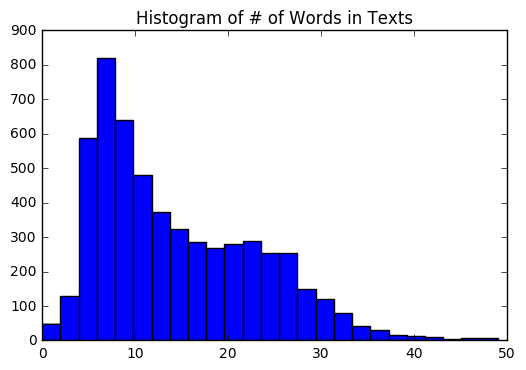

In [2]:
save_file_name = os.path.join('temp','temp_spam_data.csv')
if os.path.isfile(save_file_name):
    text_data = []
    with open(save_file_name,'r') as temp_output_file:
        reader = csv.reader(temp_output_file)
        for row in reader:
            text_data.append(row)
else:
    zip_url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    r = requests.get(zip_url)
    z = ZipFile(io.BytesIO(r.content))
    file = z.read('SMSSpamCollection')
    text_data = file.decode()
    text_data = text_data.encode('ascii',errors='ignore')
    text_data = text_data.decode().split('\n')
    text_data = [x.split('\t') for x in text_data if len(x)>=1]
    
    with open(save_file_name,'w') as temp_output_file:
        writer = csv.writer(temp_output_file)
        writer.writerows(text_data)
texts = [x[1] for x in text_data]
target = [x[0] for x in text_data]
target = [1 if x=='spam' else 0 for x in target]

texts = [x.lower() for x in texts] #转换为小写
texts = [''.join(c for c in x if c not in string.punctuation) for x in texts] #移除标点符号
texts = [''.join(c for c in x if c not in '0123456789') for x in texts] #移除数字
texts = [' '.join(x.split()) for x in texts] #移除空白
#计算最长句子大小
text_lengths = [len(x.split()) for x in texts]
text_lengths = [x for x in text_lengths if x < 50]
plt.hist(text_lengths,bins=25)
plt.title('Histogram of # of Words in Texts')
sentence_size = 25
min_word_freq = 3    
plt.show()

In [3]:
#tensorflow自带分词器VocabularyProcessor()
vocab_processor = learn.preprocessing.VocabularyProcessor(sentence_size,min_frequency=min_word_freq)
vocab_processor.fit_transform(texts)
embedding_size = len(vocab_processor.vocabulary_)
#分割数据集为训练集和测试集
train_indices = np.random.choice(len(texts),round(len(texts)*0.8),replace=False)
test_indices = np.array(list(set(range(len(texts)))-set(train_indices)))
texts_train = [x for ix,x in enumerate(texts) if ix in train_indices]
texts_test = [x for ix,x in enumerate(texts) if ix in test_indices]
target_train = [x for ix,x in enumerate(target) if ix in train_indices]
target_test = [x for ix,x in enumerate(target) if ix in test_indices]
#声明词嵌入矩阵
identity_mat = tf.diag(tf.ones(shape=[embedding_size]))

A = tf.Variable(tf.random_normal(shape=[embedding_size,1]))
b = tf.Variable(tf.random_normal(shape=[1,1]))
x_data = tf.placeholder(shape=[sentence_size],dtype=tf.int32)
y_target = tf.placeholder(shape=[1,1],dtype=tf.float32)

x_embed = tf.nn.embedding_lookup(identity_mat,x_data)
x_col_sums = tf.reduce_sum(x_embed,0)

x_col_sums_2D = tf.expand_dims(x_col_sums,0)
model_output = tf.add(tf.matmul(x_col_sums_2D,A),b)

#声明训练模型的损失函数、预测函数和优化器
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=model_output,labels=y_target))
prediction = tf.sigmoid(model_output)
train_step = tf.train.GradientDescentOptimizer(0.001).minimize(loss)

In [4]:
init = tf.initialize_all_variables()
sess.run(init)

loss_vec = []
train_acc_all = []
train_acc_avg = []
for ix,t in enumerate(vocab_processor.fit_transform(texts_train)):
    y_data = [[target_train[ix]]]
    sess.run(train_step,feed_dict={x_data:t,y_target:y_data})
    temp_loss = sess.run(loss,feed_dict={x_data:t,y_target:y_data})
    loss_vec.append(temp_loss)
    
    if (ix+1) % 10 == 0:
        print('Training Observation #' + str(ix+1) + ': Loss = ' + str(temp_loss))
    [[temp_pred]] = sess.run(prediction,feed_dict={x_data:t,y_target:y_data})
    train_acc_temp = target_train[ix]==np.round(temp_pred)
    train_acc_all.append(train_acc_temp)
    if len(train_acc_all) >= 50:
        train_acc_avg.append(np.mean(train_acc_all[-50:]))

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Training Observation #10: Loss = 9.545351
Training Observation #20: Loss = 5.88455
Training Observation #30: Loss = 3.9939697
Training Observation #40: Loss = 3.5798464
Training Observation #50: Loss = 0.00023631282
Training Observation #60: Loss = 2.7195547
Training Observation #70: Loss = 0.121294245
Training Observation #80: Loss = 0.62758905
Training Observation #90: Loss = 0.21000326
Training Observation #100: Loss = 2.6374543
Training Observation #110: Loss = 0.0031235858
Training Observation #120: Loss = 0.004683068
Training Observation #130: Loss = 4.9761118e-05
Training Observation #140: Loss = 0.9864392
Training Observation #150: Loss = 0.3307791
Training Observation #160: Loss = 0.00049460505
Training Observation #170: Loss = 1.040765e-05
Training Observation #180: Loss = 0.22561485
Training Observation #190: Loss = 0.8007037
Training Observation #200: Loss = 6.1761985
Training Observation #210: Loss =

In [5]:
print('Getting Test Set Accuracy')
test_acc_all = []
for ix,t in enumerate(vocab_processor.fit_transform(texts_test)):
    y_data = [[target_test[ix]]]
    if (ix+1) % 50 == 0:
        print('Test Observation #' + str(ix+1))
    [[temp_pred]] = sess.run(prediction,feed_dict={x_data:t,y_target:y_data})
    test_acc_temp = target_test[ix]==np.round(temp_pred)
    test_acc_all.append(test_acc_temp)
print('\nOverall Test Accuracy:{}'.format(np.mean(test_acc_all)))

Getting Test Set Accuracy
Test Observation #50
Test Observation #100
Test Observation #150
Test Observation #200
Test Observation #250
Test Observation #300
Test Observation #350
Test Observation #400
Test Observation #450
Test Observation #500
Test Observation #550
Test Observation #600
Test Observation #650
Test Observation #700
Test Observation #750
Test Observation #800
Test Observation #850
Test Observation #900
Test Observation #950
Test Observation #1000
Test Observation #1050
Test Observation #1100

Overall Test Accuracy:0.8278026905829596
